# DD2437 ANN & Deep Learning Lab2:RBF and SOM

### Imports and functions

In [22]:
%matplotlib notebook
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation

# 3.1 Batch RBF
def rbf_gaussian(x, my, sigma):
    """
    Calculate gaussian of data sample x and unit in position my
    :param vector x: sample data
    :param vector my: unit i location
    :param float sigma: variance
    :return: the calculated gaussian
    """
    norm = np.linalg.norm(x - my)
    gaussian = np.exp(-math.pow(norm, 2) / (2*math.pow(sigma, 2)))
    return gaussian


def generate_rbf_units(X, n):
    """
    Generate vector of length n containing location of RBF's and variance sigma
    :param vector X: vector containing data samples
    :param int n: # of rbf units in network
    :return: Vector of length n containing location of RBF's and float sigma
    """
    if X.shape[0] >= n:
        MY = np.zeros(n)
        MY[0] = X[0]
        MY[-1] = X[-1]
        if n > 2:
            step = X.shape[0] / (n - 1)
            for i in range(1, n-1):
                MY[i] = X[math.floor((i)*step)]
    else:
        x_max = np.amax(X)
        MY = np.random.rand(n)*x_max
        for i in range(X.shape[0]):
            MY[i] = X[i]
    sigma = (np.amax(X) - np.amin(X))/n
    return MY, sigma


def generate_PHI(X, MY, sigma):
    """
    Generate the PHI matrix containing unit gaussians for each sample
    :param vector X: Vector containing data samples
    :param vector MY: Vector containing start location of RBF's
    :param float sigma: Float indicating variance of RBF's
    :return: N x n matrix containing gaussian values for each unit and sample
    """
    PHI = np.zeros((X.shape[0], MY.shape[0]))
    for i in range(0, PHI.shape[0]):
        for j in range(0, PHI.shape[1]):
            PHI[i, j] = rbf_gaussian(X[i], MY[j], sigma)
    return PHI

    
def rbf_train_batch(PHI, T):
    """
    Batch train weights
    :param matrix PHI: N x n matrix of rbf_gaussians (n=#units, N=#samples)
    :param vector T: N Vector containing labels for samples
    :return: n Vector containing unit weights
    """
    arg1 = np.dot(PHI.T, PHI)
    arg2 = np.dot(PHI.T, T)
    W = np.dot(np.linalg.inv(arg1), arg2)
    return W


def rbf_predict(X, MY, sigma, W):
    """
    Predict targets for data sample X
    :param vector/matrix X: data samples to predict
    :param vector MY: start locations of RBF units
    :param float sigma: variance of RBF units
    :param vector W: vector containing weights
    :return: vector T containing targets for data sample X
    """
    PHI = generate_PHI(X, MY, sigma)
    T = np.dot(PHI, W)
    return T


def r_error(T_predict, T_true):
    """
    Calculate absolute residual error of prediction compared to true value
    :param vector T_predict: vector containing predictions for samples
    :param vector T_true: vector containing true values of samples
    :return: float absolute residual error
    """
    r = np.mean(np.abs(T_predict - T_true))
    return r
    

# 3.2 Online RBF delta rule
def rbf_train_batch_delta(PHI, T, epochs, eta):
    """
    Train rbf network using online delta rule
    :param matrix PHI: N x n containing gaussian values for each unit and sample
    :param vector T: containing training targets
    :param int epochs: number of epochs to iterate
    :param float eta: learning rate
    :return: W vector, list of predictions, list of residual errors
    """
    W = np.random.randn(PHI.shape[1])
    r_list = []
    T_predict_list = []
    for epoch in range(epochs):
        error = T - np.dot(PHI, W.T)
        delta_W = eta * np.dot(PHI.T, error)
        W += delta_W
        T_predict = np.dot(PHI, W)
        r = r_error(T_predict, T)
        r_list.append(r)
        T_predict_list.append(T_predict)
    return W, T_predict_list, r_list



def rbf_train_online_delta(PHI, T, epochs, eta):
    """
    Train rbf network using online delta rule
    :param matrix PHI: N x n containing gaussian values for each unit and sample
    :param vector T: containing training targets
    :param int epochs: number of epochs to iterate
    :param float eta: learning rate
    :return: W vector, list of predictions, list of residual errors
    """
    W = np.random.randn(PHI.shape[1])
    r_list = []
    T_predict_list = []
    for epoch in range(epochs):
        index_shuffle = np.arange(T.shape[0])
        np.random.shuffle(index_shuffle)
        for i in index_shuffle:
            error = T[i] - np.dot(PHI[i, :], W.T)
            delta_W = eta * error * PHI[i, :]
            W += delta_W
        T_predict = np.dot(PHI, W)
        r = r_error(T_predict, T)
        r_list.append(r)
        T_predict_list.append(T_predict)
    return W, T_predict_list, r_list



## Part I RBF

### RBF Pre-cursor questions
* N = 1 is lower bound of the number of training samples.
* If n = N the system of linear equations would be square, either it has 1 unique solution if consistent or none if inconsistent.
* The solution exists when the weights are independant or if they are dependant but the constants satisfy this dependance.
* It is good for understanding the complexity needed in the network to properly capture the system. However it gives no information about overfitting and generalisation.

### 3.1 Batch mode training using leaste squares - supervised learning of network weights

Sin prediction evolution from n=1 to 13


<IPython.core.display.Javascript object>


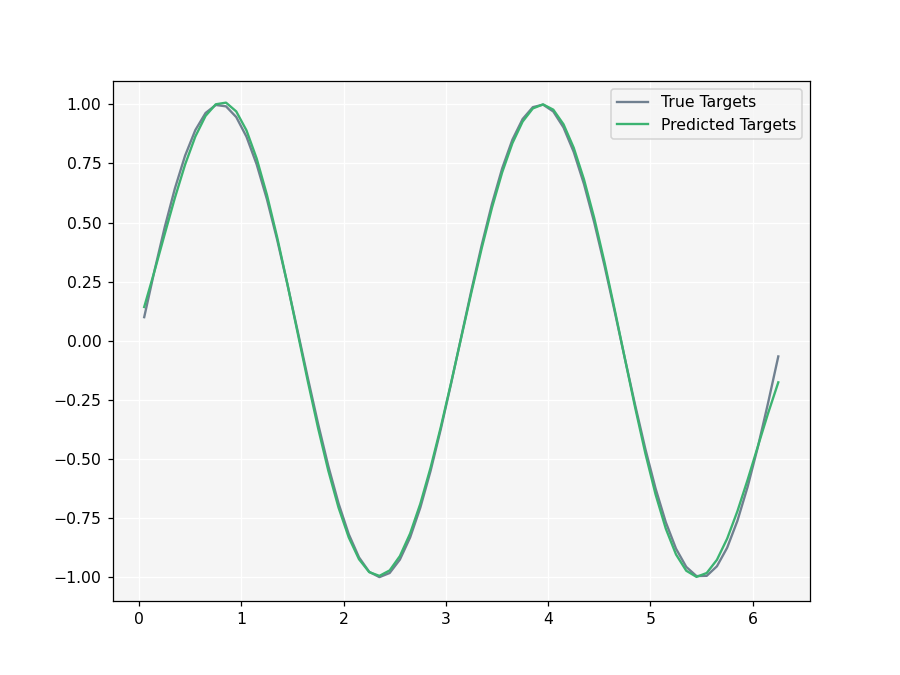

MovieWriter ffmpeg unavailable; using Pillow instead.


R = 0.0643948449965167 < 0.1 achieved with 6 RBF units
R = 0.008823269204605733 < 0.01 achieved with 12 RBF units


<IPython.core.display.Javascript object>


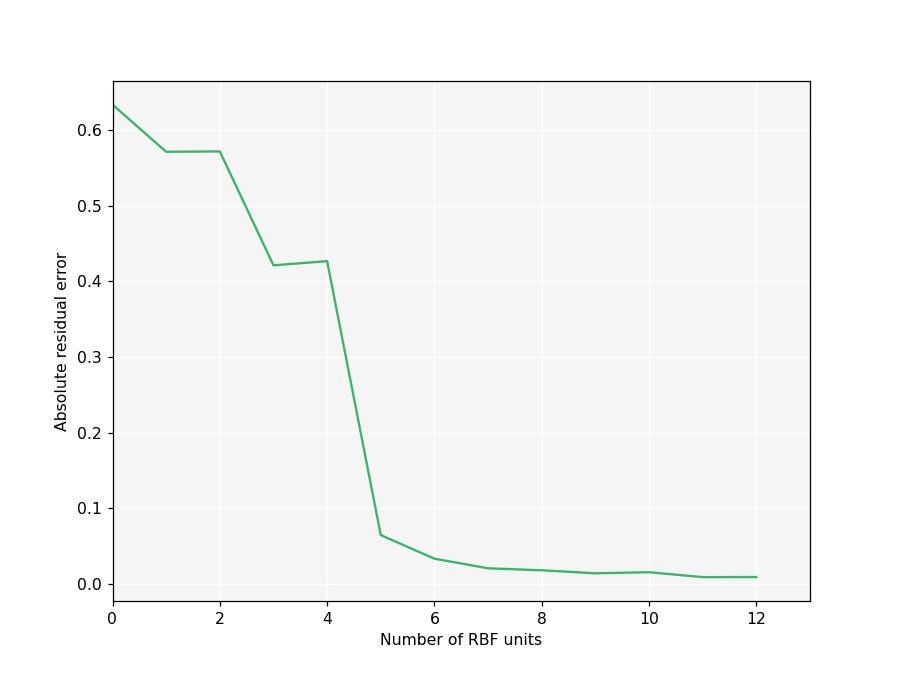


Square prediction evolution from n=1 to 13


<IPython.core.display.Javascript object>


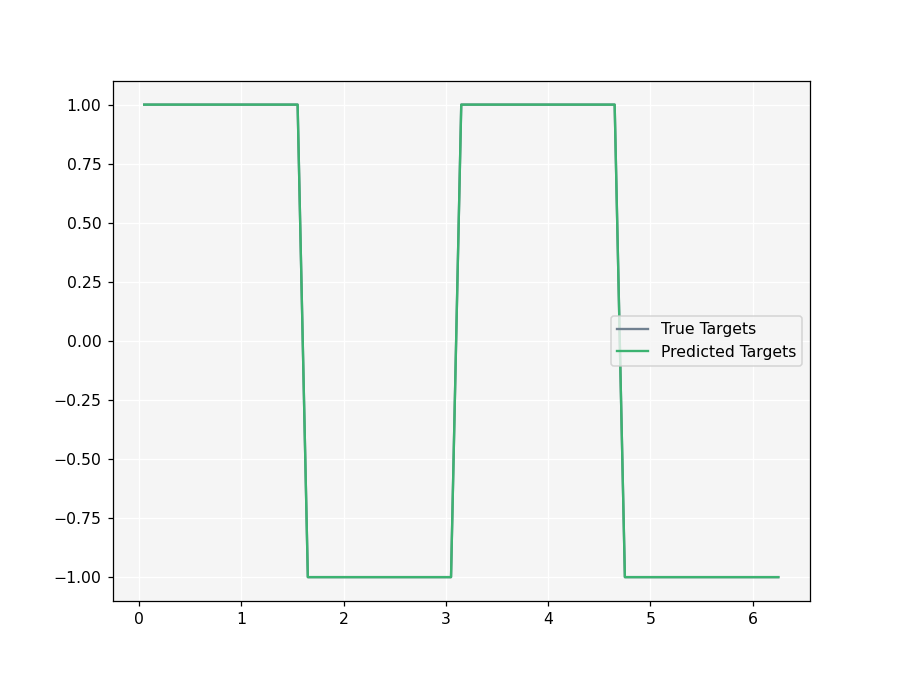

R = 0.0 < 0.1 achieved with 6 RBF units
R = 0.0 < 0.01 achieved with 6 RBF units
R = 0.0 < 0.001 achieved with 6 RBF units


<IPython.core.display.Javascript object>


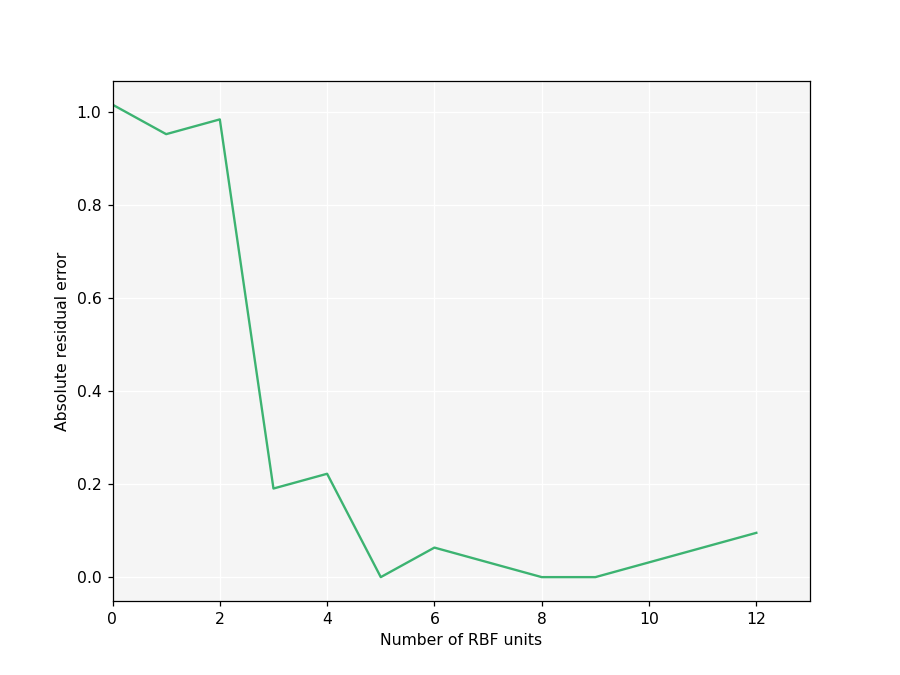

In [68]:
# Generate data
def function_sin(x):
    """
    The first function to study (with sclar value)
    """
    return np.sin(2*x)


def function_square(x):
    """
    The second function to study (with scalar value)
    """
    return np.where(function_sin(x) >= 0, 1, -1)
    

def generate_data(function):
    """
    Generate data according to functon string
    :param string function: Decides which function to generate "sin", "square"
    :return: sample data and corresponding labels X_train, T_train, X_test, T_test
    """
    T_train, T_test = None, None
    X_train = np.arange(0, 2*np.pi, 0.1).T
    X_test = np.arange(0.05, 2*np.pi, 0.1).T
    if function == "sin":
        T_train = function_sin(X_train)
        T_test = function_sin(X_test)
    elif function == "square":
        T_train = function_square(X_train)
        T_test = function_square(X_test)
    return X_train, T_train, X_test, T_test


# Calc and plot predictions and errors
def rbf_predict_error(X_train, T_train, X_test, T_test, n, sigma_factor=1, transform="none"):
    """
    Predict and calculate absolute residual error using RBF and given data
    :param vector X_train: training samples
    :param vector T_train: training targets
    :param vector X_test: testing samples
    :param vector T_test: testing samples
    :param int n: Number of RBF units
    :param float sigma_factor: scales the size of the RBF's which when =1 span the range of data
    :param string transform: string which didcates which transformation function should be applied to the output "none", "step"
    :return: float r absolute residual error, vector T_predict contining predictions
    """
    MY, sigma = generate_rbf_units(X_train, n)
    sigma *= sigma_factor
    PHI = generate_PHI(X_train, MY, sigma)
    W = rbf_train_batch(PHI, T_train)
    T_predict = rbf_predict(X_test, MY, sigma, W)
    if transform=="step":
        T_predict[T_predict >= 0] = 1
        T_predict[T_predict < 0] =-1
    r = r_error(T_predict, T_test)
    return r, T_predict


def rbf_plot(T_predict, T_test, x_range):
    """
    Plot prediction and true tragets from list of T-predictions
    """
    plt.rcParams['figure.figsize'] = [8, 6]
    plt.rcParams['axes.facecolor'] = 'whitesmoke'
    fig, ax = plt.subplots()
    ax.grid(c="white")
    ax.plot(x_range, T_test,c="slategray", label="True Targets")
    predict, = ax.plot(x_range, T_predict[0],c="mediumseagreen", label="Predicted Targets")
    animate = lambda f: predict.set_data(x_range, T_predict[f])
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames = len(T_predict), interval = 500)
    plt.legend()
    plt.show()
    return ani
    

def residual_error_plot(R):
    """
    Plot residual error
    """
    plt.figure()
    plt.rcParams['figure.figsize'] = [8, 6]
    plt.rcParams['axes.facecolor'] = 'whitesmoke'
    plt.grid(c="white")
    plt.plot(range(0, len(R)), R, c="mediumseagreen")
    plt.xlim(0, len(R))
    plt.xlabel("Number of RBF units")
    plt.ylabel("Absolute residual error")
    plt.show()
    
# Predicting sin & square
X_train_sin, T_train_sin, X_test_sin, T_test_sin = generate_data("sin")
X_train_square, T_train_square, X_test_square, T_test_square = generate_data("square")
sin_R = []
sin_T_list = []
square_R = []
square_T_list = []
max_rbf = 13

for n in range(1, max_rbf+1):
    sin_r, sin_T_predict = rbf_predict_error(X_train_sin, T_train_sin, X_test_sin, T_test_sin, n)
    square_r, square_T_predict = rbf_predict_error(X_train_square, T_train_square, X_test_square, T_test_square, n, transform="step")
    sin_R.append(sin_r)
    sin_T_list.append(sin_T_predict)
    square_R.append(square_r)
    square_T_list.append(square_T_predict)

# Plotting predictions and absolute residual errors
print(f"Sin prediction evolution from n=1 to {max_rbf}")
sin_ani = rbf_plot(sin_T_list, T_test_sin, X_test_sin)
sin_ani.save("rbf_sine.gif")
check1, check2 = False, False
for i, r in enumerate(sin_R):
    if r < 0.1 and not check1:
        print(f"R = {r} < 0.1 achieved with {i+1} RBF units")
        check1 = True
    if r < 0.01 and not check2:
        print(f"R = {r} < 0.01 achieved with {i+1} RBF units")
        check2 = True
    if r < 0.001:
        print(f"R = {r} < 0.001 achieved with {i+1} RBF units")
        break
residual_error_plot(sin_R)
print("")
print(f"Square prediction evolution from n=1 to {max_rbf}")
square_ani = rbf_plot(square_T_list, T_test_square, X_test_square)
check1, check2 = False, False
for i, r in enumerate(square_R):
    if r < 0.1 and not check1:
        print(f"R = {r} < 0.1 achieved with {i+1} RBF units")
        check1 = True
    if r < 0.01 and not check2:
        print(f"R = {r} < 0.01 achieved with {i+1} RBF units")
        check2 = True
    if r < 0.001:
        print(f"R = {r} < 0.001 achieved with {i+1} RBF units")
        break
residual_error_plot(square_R)

### 3.1 Questions
* 6 RBF units are enough to reach R < 0.1 for the sine function and 12 units achieve R < 0.01. 62 RBF units were required to get below R < 0.001. The network manages to approximate the shape of sine fairly well except towards the end, where it's slightly out of shape, don't know why that is.
* Without the step function applied to the output the network achieves R ≈ 0.3, with the step function it achieves R = 0 with 6 RBF units. The step transform should be particularly useful for binary classification.

### 3.2 Regression with noise

In [37]:
# Generate data
def function_sin(x):
    """
    The first function to study (with sclar value)
    """
    return np.sin(2*x)


def function_square(x):
    """
    The second function to study (with scalar value)
    """
    return np.where(function_sin(x) >= 0, 1, -1)
    

def generate_data_noise(function):
    """
    Generate data according to functon string and introduce 0 mean gaussian noise with variance 0.1
    :param string function: Decides which function to generate "sin", "square"
    :return: sample data and corresponding labels X_train, T_train, X_test, T_test
    """
    T_train, T_test = None, None
    X_train = np.arange(0, 2*np.pi, 0.1).T
    X_test = np.arange(0.05, 2*np.pi, 0.1).T
    if function == "sin":
        T_train = function_sin(X_train)
        T_test = function_sin(X_test)
    elif function == "square":
        T_train = function_square(X_train)
        T_test = function_square(X_test)
    X_train += np.random.normal(0, 0.1, X_train.shape)
    X_test += np.random.normal(0, 0.1, X_test.shape)
    return X_train, T_train, X_test, T_test


#Prediction function
def rbf_delta_predict_error(X_train, T_train, X_test, T_test, n, epochs, eta, sigma_factor=1, learning="online", transform="none"):
    """
    Predict and calculate absolute residual error using online delta rule RBF and given data
    :param vector X_train: training samples
    :param vector T_train: training targets
    :param vector X_test: testing samples
    :param vector T_test: testing samples
    :param int n: Number of RBF units
    :param int epochs: number of epochs
    :param float eta: learning rate
    :param float sigma_factor: scales the size of the RBF's which when =1 span the range of data
    :param string learning: learning scheme "online", "batch"
    :param string transform: string which didcates which transformation function should be applied to the output "none", "step"
    :return: float r absolute residual error, vector T_predict contining predictions
    """
    MY, sigma = generate_rbf_units(X_train, n)
    sigma *= sigma_factor
    PHI = generate_PHI(X_train, MY, sigma)
    if learning == "online":
        W, _, _ = rbf_train_online_delta(PHI, T_train, epochs, eta)
    elif learning == "batch":
        W, _, _ = rbf_train_batch_delta(PHI, T_train, epochs, eta)
    else:
        return
    T_predict = rbf_predict(X_test, MY, sigma, W)
    if transform=="step":
        T_predict[T_predict >= 0] = 1
        T_predict[T_predict < 0] =-1
    r = r_error(T_predict, T_test)
    return r, T_predict

In [38]:
# Test effect of number and size of RBF
epochs = 100
eta = 0.01
num_rbf = [1, 4, 8, 12]
width_factor_rbf = [0.8, 1, 1.2]
X_train_sin, T_train_sin, X_test_sin, T_test_sin = generate_data_noise("sin")
X_train_square, T_train_square, X_test_square, T_test_square = generate_data_noise("square")

sin_online_num_sigma = np.zeros((4, 3))
sin_batch_num_sigma = np.zeros((4, 3))
square_online_num_sigma = np.zeros((4, 3))
square_batch_num_sigma = np.zeros((4, 3))

print("Absolute residual error for Online and Batch training")
for i, n in enumerate(num_rbf):
    for j, sigma_factor in enumerate(width_factor_rbf):
        r_sin_online, _ = rbf_delta_predict_error(X_train_sin, T_train_sin, X_test_sin, T_test_sin, n, epochs, eta, sigma_factor, learning="online", transform="none")
        r_square_online, _ = rbf_delta_predict_error(X_train_square, T_train_square, X_test_square, T_test_square, n, epochs, eta, sigma_factor, learning="online", transform="step")
        r_sin_batch, _ = rbf_delta_predict_error(X_train_sin, T_train_sin, X_test_sin, T_test_sin, n, epochs, eta, sigma_factor, learning="batch", transform="none")
        r_square_batch, _ = rbf_delta_predict_error(X_train_square, T_train_square, X_test_square, T_test_square, n, epochs, eta, sigma_factor, learning="batch", transform="step")
        
        sin_online_num_sigma[i, j] = r_sin_online
        sin_batch_num_sigma[i, j] = r_sin_batch
        square_online_num_sigma[i, j] = r_square_online
        square_batch_num_sigma[i, j] = r_square_batch

print(f"Sine, number of RBF = {num_rbf}, sigma evenly spaced and multiplied with {width_factor_rbf}")
for i in range(len(num_rbf)):
    print(sin_online_num_sigma[i, :], "  ", sin_batch_num_sigma[i, :])
print(f"Square, number of RBF = {num_rbf}, sigma evenly spaced and multiplied with {width_factor_rbf}")
for i in range(len(num_rbf)):
    print(square_online_num_sigma[i, :], "  ", square_batch_num_sigma[i, :])

Absolute residual error for Online and Batch training
Sine, number of RBF = [1, 4, 8, 12], sigma evenly spaced and multiplied with [0.8, 1, 1.2]
[0.63134276 0.6336181  0.63441638]    [0.63131014 0.63354815 0.63441183]
[0.40337983 0.45846382 0.51772421]    [0.40053056 0.45058354 0.48058729]
[0.14082625 0.19681841 0.29160684]    [0.13446189 0.15502281 0.3158288 ]
[0.16518979 0.13077293 0.11908788]    [0.13408705 0.11965809 0.1248148 ]
Square, number of RBF = [1, 4, 8, 12], sigma evenly spaced and multiplied with [0.8, 1, 1.2]
[1.01587302 1.01587302 1.01587302]    [1.01587302 1.01587302 1.01587302]
[0.25396825 0.0952381  0.47619048]    [0.25396825 0.12698413 0.47619048]
[0.0952381 0.0952381 0.0952381]    [0.0952381 0.0952381 0.0952381]
[0.12698413 0.0952381  0.12698413]    [0.0952381  0.12698413 0.12698413]


<IPython.core.display.Javascript object>


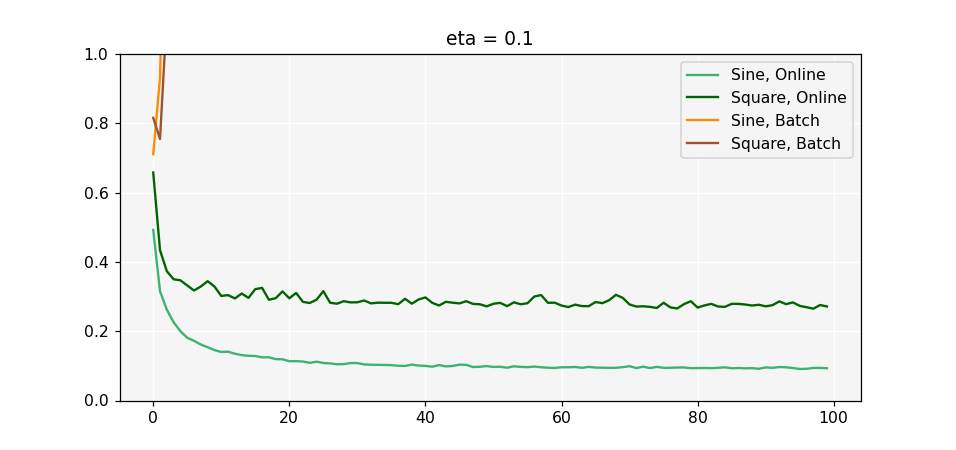

<IPython.core.display.Javascript object>


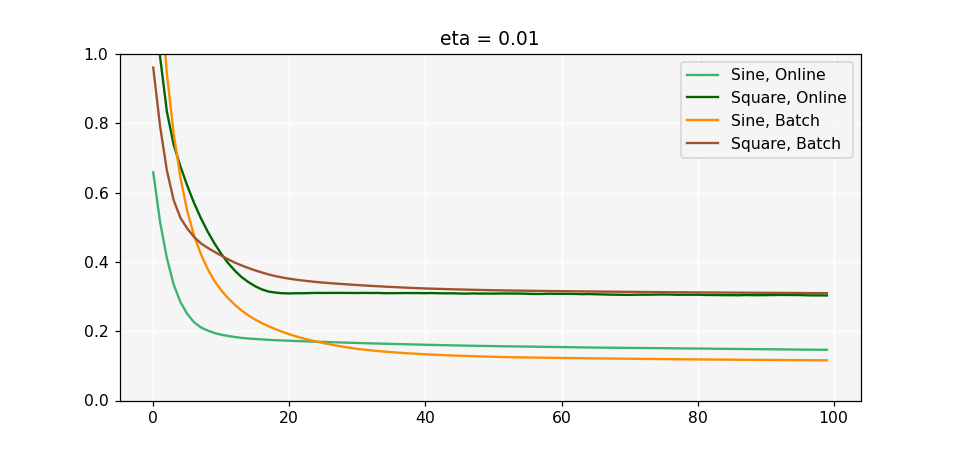

<IPython.core.display.Javascript object>


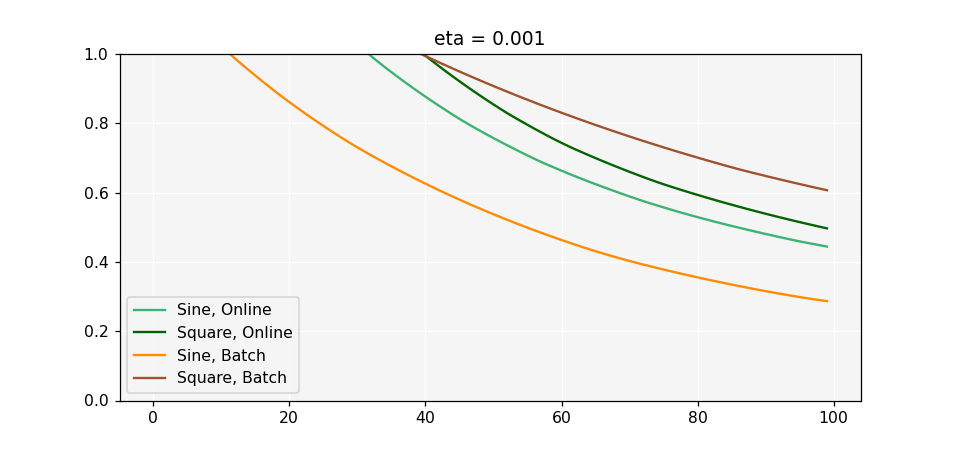

In [72]:
# Test effect of learning rate on convergence
epochs = 100
ETA = [0.1, 0.01, 0.001]
n = 12
X_train_sin, T_train_sin, X_test_sin, T_test_sin = generate_data_noise("sin")
X_train_square, T_train_square, X_test_square, T_test_square = generate_data_noise("square")

MY_sin, sigma = generate_rbf_units(X_train_sin, n)
PHI_sin = generate_PHI(X_train_sin, MY_sin, sigma)
MY_square, sigma = generate_rbf_units(X_train_square, n)
PHI_square = generate_PHI(X_train_square, MY_square, sigma)
o_e_list = []
b_e_list = []

for eta in ETA:
    _, _, sin_online_errors = rbf_train_online_delta(PHI_sin, T_train_sin, epochs, eta)
    _, _, sin_batch_errors = rbf_train_batch_delta(PHI_sin, T_train_sin, epochs, eta)
    _, _, square_online_errors = rbf_train_online_delta(PHI_square, T_train_square, epochs, eta)
    _, _, square_batch_errors = rbf_train_batch_delta(PHI_square, T_train_square, epochs, eta)
    plt.rcParams['figure.figsize'] = [8.5, 4]
    plt.rcParams['axes.facecolor'] = 'whitesmoke'
    plt.figure()
    plt.title(f"eta = {eta}")
    plt.grid(c="white")
    plt.plot(range(epochs), sin_online_errors, c="mediumseagreen", label="Sine, Online")
    plt.plot(range(epochs), square_online_errors, c="darkgreen", label="Square, Online")
    plt.plot(range(epochs), sin_batch_errors, c="darkorange", label="Sine, Batch")
    plt.plot(range(epochs), square_batch_errors, c="sienna", label="Square, Batch")
    plt.ylim(0, 1)
    plt.legend()  
    plt.show()

<IPython.core.display.Javascript object>


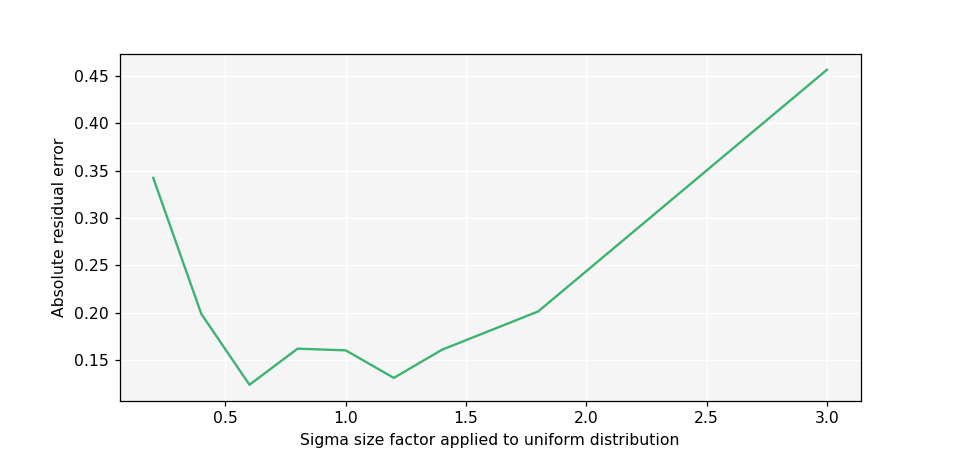

In [66]:
# Varying RBF size
epochs = 100
eta = 0.01
n = 12
width_factor_rbf = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.8, 3.0]
error_list = []

X_train_sin, T_train_sin, X_test_sin, T_test_sin = generate_data_noise("sin")
for sigma_factor in width_factor_rbf:
    r, _ = rbf_delta_predict_error(X_train_sin, T_train_sin, X_test_sin, T_test_sin, n, epochs, eta, sigma_factor, learning="batch", transform="none")
    error_list.append(r)
plt.figure()
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.grid(c="white")
plt.plot(width_factor_rbf, error_list, c="mediumseagreen")
plt.xlabel("Sigma size factor applied to uniform distribution")
plt.ylabel("Absolute residual error")
plt.show()

<IPython.core.display.Javascript object>


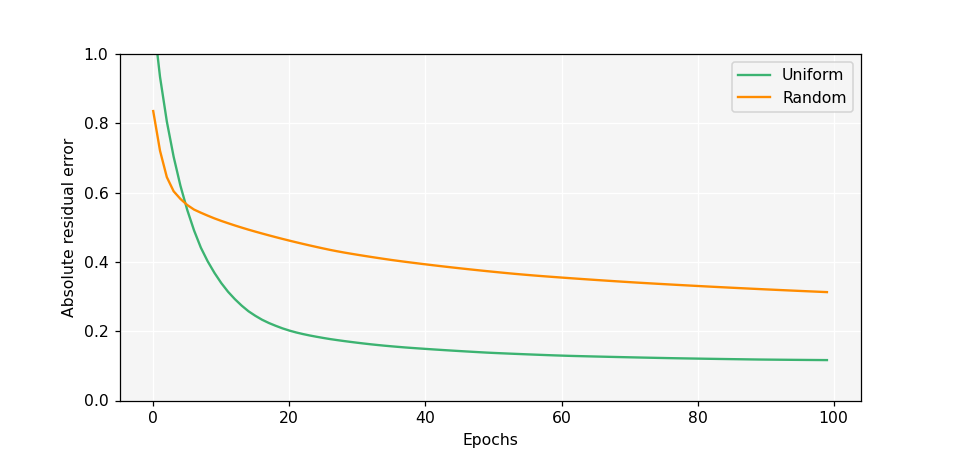

In [65]:
# Random initialization of RBF position vs uniform distribution
epochs = 100
eta = 0.01
n = 12
X_train, T_train, X_test, T_test = generate_data_noise("sin")
MY, sigma = generate_rbf_units(X_train_sin, n)
MY_random = np.random.rand(n) * 2 * np.pi
PHI = generate_PHI(X_train, MY, sigma)
PHI_random = generate_PHI(X_train, MY_random, sigma)

_, _, errors = rbf_train_batch_delta(PHI, T_train, epochs, eta)
_, _, errors_random = rbf_train_batch_delta(PHI_random, T_train, epochs, eta)
plt.rcParams['figure.figsize'] = [8.5, 4]
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.figure()
plt.grid(c="white")
fig.suptitle("Error comparison uniform vs random RBF distribution")
plt.plot(range(epochs), errors, c="mediumseagreen", label="Uniform")
plt.plot(range(epochs), errors_random, c="darkorange", label="Random")
plt.ylim(0, 1)
plt.xlabel("Epochs")
plt.ylabel("Absolute residual error")
plt.legend()
plt.show()

In [74]:
# Comparison on clean test data with and without noise in training
epochs = 100
eta = 0.01
n = 12
X_train_noise, T_train, _, T_test = generate_data_noise("sin")
X_train, _, X_test, _ = generate_data("sin")

r_online, _ = rbf_delta_predict_error(X_train, T_train, X_test, T_test, n, epochs, eta, sigma_factor=1, learning="online", transform="none")
r_online_noise, _ = rbf_delta_predict_error(X_train_noise, T_train, X_test, T_test, n, epochs, eta, sigma_factor=1, learning="online", transform="none")
r_batch, _ = rbf_delta_predict_error(X_train, T_train, X_test, T_test, n, epochs, eta, sigma_factor=1, learning="batch", transform="none")
r_batch_noise, _ = rbf_delta_predict_error(X_train_noise, T_train, X_test, T_test, n, epochs, eta, sigma_factor=1, learning="batch", transform="none")

print(f"R = {r_online} for Online without training noise")
print(f"R = {r_batch} for Batch without training noise")
print(f"R = {r_online_noise} for Online with training noise")
print(f"R = {r_batch_noise} for Batch with training noise")

R = 0.09025654618530232 for Online without training noise
R = 0.11965739288158901 for Batch without training noise
R = 0.1886009140390709 for Online with training noise
R = 0.1328098963140639 for Batch with training noise


R = 0.5730656231783581 for Single Layer Perceptron with Backprop on Sine function
R = 0.11894707856761014 for RBF network with Batch Delta Rule on Sine function
R = 0.8445026479520471 for Single Layer Perceptron with Backprop on Square function with no output transform
R = 0.2828346745779915 for RBF network with Batch Delta Rule on Square function with no output transform


<IPython.core.display.Javascript object>


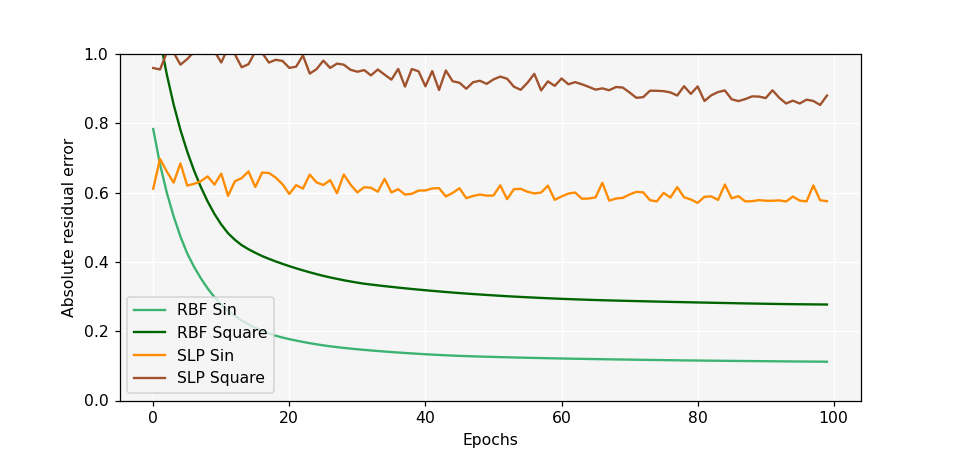

In [83]:
# Comparison with single hidden layer perceptron
from sklearn.neural_network import MLPRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

epochs = 100
eta = 0.01
n = 12
X_train_sin, T_train_sin, X_test_sin, T_test_sin = generate_data_noise("sin")
X_train_square, T_train_square, X_test_square, T_test_square = generate_data_noise("square")

slp = MLPRegressor(hidden_layer_sizes=[n], activation='logistic', solver='sgd', learning_rate_init=eta, max_iter=epochs, early_stopping=False, validation_fraction=0)

slp.fit(X_train_sin.reshape(-1, 1), T_train_sin)
slp_T_predict_sin = slp.predict(X_test_sin.reshape(-1, 1))
slp_r_sin = r_error(slp_T_predict_sin, T_test_sin)
rbf_r_sin, _ = rbf_delta_predict_error(X_train_sin, T_train_sin, X_test_sin, T_test_sin, n, epochs, eta, sigma_factor=1, learning="batch", transform="none")

slp.fit(X_train_square.reshape(-1, 1), T_train_square)
slp_T_predict_square = slp.predict(X_test_square.reshape(-1, 1))
slp_r_square = r_error(slp_T_predict_square, T_test_square)
rbf_r_square, _ = rbf_delta_predict_error(X_train_square, T_train_square, X_test_square, T_test_square, n, epochs, eta, sigma_factor=1, learning="batch", transform="none")

print(f"R = {slp_r_sin} for Single Layer Perceptron with Backprop on Sine function")
print(f"R = {rbf_r_sin} for RBF network with Batch Delta Rule on Sine function")
print(f"R = {slp_r_square} for Single Layer Perceptron with Backprop on Square function with no output transform")
print(f"R = {rbf_r_square} for RBF network with Batch Delta Rule on Square function with no output transform")

MY, sigma = generate_rbf_units(X_train_sin, n)
PHI = generate_PHI(X_train_sin, MY, sigma)
_, _, rbf_errors_sin = rbf_train_batch_delta(PHI, T_train_sin, epochs, eta)

MY, sigma = generate_rbf_units(X_train_square, n)
PHI = generate_PHI(X_train_square, MY, sigma)
_, _, rbf_errors_square = rbf_train_batch_delta(PHI, T_train_square, epochs, eta)

slp_errors_sin = []
slp_errors_square = []
for epoch in range(1, epochs+1):
    slp = MLPRegressor(hidden_layer_sizes=[n], activation='logistic', solver='sgd', learning_rate_init=eta, max_iter=epoch, early_stopping=False, validation_fraction=0)
    slp.fit(X_train_sin.reshape(-1, 1), T_train_sin)
    slp_T_sin = slp.predict(X_train_sin.reshape(-1, 1))
    slp_r_sin = r_error(slp_T_sin, T_train_sin)
    slp_errors_sin.append(slp_r_sin)
    
    slp.fit(X_train_square.reshape(-1, 1), T_train_square)
    slp_T_square = slp.predict(X_train_square.reshape(-1, 1))
    slp_r_square = r_error(slp_T_square, T_train_square)
    slp_errors_square.append(slp_r_square)
    
plt.rcParams['figure.figsize'] = [8.5, 4]
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.figure()
plt.grid(c="white")
fig.suptitle("Training error over epochs for SLP and RBF networks")
plt.plot(range(epochs), rbf_errors_sin, c="mediumseagreen", label="RBF Sin")
plt.plot(range(epochs), rbf_errors_square, c="darkgreen", label="RBF Square")
plt.plot(range(epochs), slp_errors_sin, c="darkorange", label="SLP Sin")
plt.plot(range(epochs), slp_errors_square, c="sienna", label="SLP Square")
plt.ylim(0, 1)
plt.xlabel("Epochs")
plt.ylabel("Absolute residual error")
plt.legend()
plt.show()